In [1]:
# Hide warnings
from logging import FATAL
import warnings

warnings.filterwarnings('ignore')

# Standard Libraries
import argparse
import json
import time
import networkx as nx
import numpy as np
import concurrent.futures
import mlflow
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pathos.pools as pp

plt.style.use('seaborn')

# Custom Libraries
import qaoa_vrp.build_graph
import qaoa_vrp.features.graph_features
import qaoa_vrp.features.tsp_features
import qaoa_vrp.build_circuit
import qaoa_vrp.clustering
import qaoa_vrp.utils
from qaoa_vrp.exp_utils import str2bool, make_temp_directory
from qaoa_vrp.plot.feasibility_graph import (
    plot_feasibility_results,
    generate_feasibility_results,
)
from qaoa_vrp.initialisation.initialisation import Initialisation
from qaoa_vrp.features.graph_features import get_graph_features
from qaoa_vrp.features.tsp_features import get_tsp_features
from qaoa_vrp.parallel.optimize_qaoa import run_qaoa_parallel_control_max_restarts

# Import Qiskit Dependencies
from qiskit import Aer, QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.aqua import aqua_globals
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, QAOA
from qiskit.algorithms.optimizers import NELDER_MEAD, COBYLA
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.applications.ising import tsp
from qiskit.visualization import plot_state_city, plot_histogram

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
filename = "instanceType_asymmetric_tsp_numNodes_4_numVehicles_1_0083a1d22a6447f69091ac552ceb8ee2.json"
instance_path = "../../data/{}".format(filename)

In [3]:
with open(instance_path) as f:
    data = json.load(f)
    G, depot_info = qaoa_vrp.build_graph.build_json_graph(data["graph"])
    num_vehicles = int(data["numVehicles"])
    threshold = float(data["threshold"])
    n_max = int(data["n_max"])

In [4]:
edge_mat = nx.linalg.graphmatrix.adjacency_matrix(G).toarray()
cost_mat = np.array(nx.attr_matrix(G, edge_attr="cost", rc_order=list(G.nodes())))
for edge in G.edges():
    G[edge[0]][edge[1]]['cost'] = 0

edge_mat = nx.linalg.graphmatrix.adjacency_matrix(G).toarray()
cost_mat = np.array(nx.attr_matrix(G, edge_attr="cost", rc_order=list(G.nodes())))

G, cluster_mapping = qaoa_vrp.clustering.create_clusters(
    G, num_vehicles, "spectral-clustering", edge_mat
)

depot_edges = list(G.edges(depot_info["id"], data=True))
depot_node = depot_info["id"]

subgraphs = qaoa_vrp.clustering.build_sub_graphs(G, depot_node, depot_edges)

# big_offset = sum(sum(cost_mat))/2 + 1
big_offset = 30
qubos = qaoa_vrp.build_circuit.build_qubos(subgraphs, depot_info, A=big_offset)

cluster_mapping = [i + 1 for i in cluster_mapping]
cluster_mapping.insert(0, 0)

qubo = qubos[0]
qubos

[\ This file has been generated by DOcplex
 \ ENCODING=ISO-8859-1
 \Problem name: CPLEX
 
 Minimize
  obj: - 120 X11 - 120 X12 - 120 X13 - 120 X21 - 120 X22 - 120 X23 - 120 X31
       - 120 X32 - 120 X33 + [ 120 X11^2 + 120 X11*X12 + 120 X11*X13
       + 120 X11*X21 + 120 X11*X31 + 120 X12^2 + 120 X12*X13 + 120 X12*X22
       + 120 X12*X32 + 120 X13^2 + 120 X13*X23 + 120 X13*X33 + 120 X21^2
       + 120 X21*X22 + 120 X21*X23 + 120 X21*X31 + 120 X22^2 + 120 X22*X23
       + 120 X22*X32 + 120 X23^2 + 120 X23*X33 + 120 X31^2 + 120 X31*X32
       + 120 X31*X33 + 120 X32^2 + 120 X32*X33 + 120 X33^2 ]/2 + 180
 Subject To
 
 Bounds
  0 <= X11 <= 1
  0 <= X12 <= 1
  0 <= X13 <= 1
  0 <= X21 <= 1
  0 <= X22 <= 1
  0 <= X23 <= 1
  0 <= X31 <= 1
  0 <= X32 <= 1
  0 <= X33 <= 1
 
 Binaries
  X11 X12 X13 X21 X22 X23 X31 X32 X33
 End]

In [5]:
from qiskit import BasicAer
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
)
from qiskit_optimization import QuadraticProgram
from qiskit.visualization import plot_histogram
from typing import List, Tuple
import numpy as np

In [6]:
qubos[0]

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 120 X11 - 120 X12 - 120 X13 - 120 X21 - 120 X22 - 120 X23 - 120 X31
      - 120 X32 - 120 X33 + [ 120 X11^2 + 120 X11*X12 + 120 X11*X13
      + 120 X11*X21 + 120 X11*X31 + 120 X12^2 + 120 X12*X13 + 120 X12*X22
      + 120 X12*X32 + 120 X13^2 + 120 X13*X23 + 120 X13*X33 + 120 X21^2
      + 120 X21*X22 + 120 X21*X23 + 120 X21*X31 + 120 X22^2 + 120 X22*X23
      + 120 X22*X32 + 120 X23^2 + 120 X23*X33 + 120 X31^2 + 120 X31*X32
      + 120 X31*X33 + 120 X32^2 + 120 X32*X33 + 120 X33^2 ]/2 + 180
Subject To

Bounds
 0 <= X11 <= 1
 0 <= X12 <= 1
 0 <= X13 <= 1
 0 <= X21 <= 1
 0 <= X22 <= 1
 0 <= X23 <= 1
 0 <= X31 <= 1
 0 <= X32 <= 1
 0 <= X33 <= 1

Binaries
 X11 X12 X13 X21 X22 X23 X31 X32 X33
End

In [24]:
tsp_qubo, offset = qubos[0].to_ising()

In [26]:
tsp_qubo

SummedOp([PauliOp(Pauli('IIIIIIIIZ'), coeff=-30.0), PauliOp(Pauli('IIIIIIIZI'), coeff=-30.0), PauliOp(Pauli('IIIIIIZII'), coeff=-30.0), PauliOp(Pauli('IIIIIZIII'), coeff=-30.0), PauliOp(Pauli('IIIIZIIII'), coeff=-30.0), PauliOp(Pauli('IIIZIIIII'), coeff=-30.0), PauliOp(Pauli('IIZIIIIII'), coeff=-30.0), PauliOp(Pauli('IZIIIIIII'), coeff=-30.0), PauliOp(Pauli('ZIIIIIIII'), coeff=-30.0), PauliOp(Pauli('IIIIIIIZZ'), coeff=15.0), PauliOp(Pauli('IIIIIIZIZ'), coeff=15.0), PauliOp(Pauli('IIIIIIZZI'), coeff=15.0), PauliOp(Pauli('IIIIIZIIZ'), coeff=15.0), PauliOp(Pauli('IIIIZIIZI'), coeff=15.0), PauliOp(Pauli('IIIIZZIII'), coeff=15.0), PauliOp(Pauli('IIIZIIZII'), coeff=15.0), PauliOp(Pauli('IIIZIZIII'), coeff=15.0), PauliOp(Pauli('IIIZZIIII'), coeff=15.0), PauliOp(Pauli('IIZIIIIIZ'), coeff=15.0), PauliOp(Pauli('IIZIIZIII'), coeff=15.0), PauliOp(Pauli('IZIIIIIZI'), coeff=15.0), PauliOp(Pauli('IZIIZIIII'), coeff=15.0), PauliOp(Pauli('IZZIIIIII'), coeff=15.0), PauliOp(Pauli('ZIIIIIZII'), coeff=15.0

In [27]:
from qiskit.opflow.primitive_ops.primitive_op import PrimitiveOp
from qiskit.opflow.primitive_ops.pauli_sum_op import PauliSumOp
from qiskit.quantum_info.operators.symplectic.sparse_pauli_op import SparsePauliOp

In [29]:
list_of_paulis = []
list_of_coeffs = []
for i in list(tsp_qubo):
    list_of_paulis.append(str(i.primitive))
    list_of_coeffs.append(i.coeff)


In [30]:
list_of_paulis

['IIIIIIIIZ',
 'IIIIIIIZI',
 'IIIIIIZII',
 'IIIIIZIII',
 'IIIIZIIII',
 'IIIZIIIII',
 'IIZIIIIII',
 'IZIIIIIII',
 'ZIIIIIIII',
 'IIIIIIIZZ',
 'IIIIIIZIZ',
 'IIIIIIZZI',
 'IIIIIZIIZ',
 'IIIIZIIZI',
 'IIIIZZIII',
 'IIIZIIZII',
 'IIIZIZIII',
 'IIIZZIIII',
 'IIZIIIIIZ',
 'IIZIIZIII',
 'IZIIIIIZI',
 'IZIIZIIII',
 'IZZIIIIII',
 'ZIIIIIZII',
 'ZIIZIIIII',
 'ZIZIIIIII',
 'ZZIIIIIII']

In [31]:
from qiskit.quantum_info import PauliTable
from qiskit.opflow.primitive_ops.pauli_sum_op import PauliSumOp
from qiskit.quantum_info.operators.symplectic.sparse_pauli_op import SparsePauliOp

for i, pauli in enumerate(list_of_paulis):
    if i == 0:
        pauli_table = PauliTable(list_of_paulis[0])
    else:
        pauli_table += PauliTable(list_of_paulis[i])


In [32]:
op_tsp = PauliSumOp(SparsePauliOp(pauli_table, coeffs=list_of_coeffs))

In [33]:
qp = QuadraticProgram()
qp.from_ising(op_tsp, offset, linear=True)
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 60 x0 - 60 x1 - 60 x2 - 60 x3 - 60 x4 - 60 x5 - 60 x6 - 60 x7 - 60 x8 +
      [ 120 x0*x1 + 120 x0*x2 + 120 x0*x3 + 120 x0*x6 + 120 x1*x2 + 120 x1*x4
      + 120 x1*x7 + 120 x2*x5 + 120 x2*x8 + 120 x3*x4 + 120 x3*x5 + 120 x3*x6
      + 120 x4*x5 + 120 x4*x7 + 120 x5*x8 + 120 x6*x7 + 120 x6*x8 + 120 x7*x8
      ]/2 + 180
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1
 0 <= x5 <= 1
 0 <= x6 <= 1
 0 <= x7 <= 1
 0 <= x8 <= 1

Binaries
 x0 x1 x2 x3 x4 x5 x6 x7 x8
End



## QAOA Approach

In [37]:
algorithm_globals.random_seed = 10598
quantum_instance = QuantumInstance(
    Aer.get_backend("aer_simulator_matrix_product_state"),
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
)
qaoa_mes = QAOA(quantum_instance=quantum_instance, reps=3)
exact_mes = NumPyMinimumEigensolver()

In [35]:
qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA
exact = MinimumEigenOptimizer(exact_mes)  # using the exact classical numpy minimum eigen solver

In [41]:
exact.solve(qp)

optimal function value: 0.0
optimal value: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
status: SUCCESS

In [38]:
qaoa_result = qaoa.solve(qp)
print(qaoa_result)

optimal function value: 0.0
optimal value: [0. 0. 1. 0. 1. 0. 1. 0. 0.]
status: SUCCESS


In [19]:
def get_filtered_samples(
    samples: List[SolutionSample],
    threshold: float = 0,
    allowed_status: Tuple[OptimizationResultStatus] = (OptimizationResultStatus.SUCCESS,),
):
    res = []
    for s in samples:
        if s.status in allowed_status and s.probability > threshold:
            res.append(s)

    return res

In [20]:
filtered_samples = get_filtered_samples(
    qaoa_result.samples, threshold=0.001, allowed_status=(OptimizationResultStatus.SUCCESS,)
)
for s in filtered_samples:
    print(s)

NameError: name 'qaoa_result' is not defined

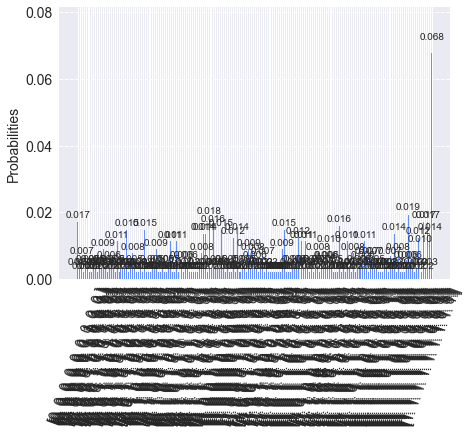

In [147]:
fvals = [s.fval for s in qaoa_result.samples]
probabilities = [s.probability for s in qaoa_result.samples]
samples_for_plot = {
     str(s.x): s.probability
    for i,s in enumerate(filtered_samples)
}
plot_histogram(samples_for_plot)

# Recursive QAOA

In [149]:
rqaoa = RecursiveMinimumEigenOptimizer(qaoa, min_num_vars=4, min_num_vars_optimizer=exact)
rqaoa_result = rqaoa.solve(qp)
print(rqaoa_result)

optimal function value: 60.0
optimal value: [0. 0. 1. 1. 0. 0. 1. 1. 0.]
status: SUCCESS


In [125]:
filtered_samples = get_filtered_samples(
    rqaoa_result.samples, threshold=0.00001
)

filtered_samples

[SolutionSample(x=array([1., 0., 0., 0., 0., 1., 0., 1., 0.]), fval=0.0, probability=1.0, status=<OptimizationResultStatus.SUCCESS: 0>)]

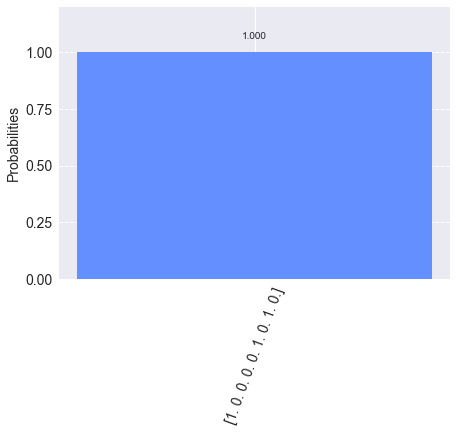

In [126]:
fvals = [s.fval for s in qaoa_result.samples]
probabilities = [s.probability for s in qaoa_result.samples]
samples_for_plot = {
     str(s.x): s.probability
    for i,s in enumerate(filtered_samples)
}
plot_histogram(samples_for_plot)

In [55]:
import qiskit.tools.jupyter
%qiskit_version_table

Look at:

`p=1`
`p=5`
`p=10`

- Use TQA for the initialisation
- Try 5 restarts 
- Run RQAOA 20 times

Plot a faceted graph for different p vals